In [1]:
# 导入需要用到的包
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
# from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

In [2]:
# 查看 users.dat
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [3]:
# 查看 movies.dat
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# 查看 ratings.dat
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
# 数据预处理
def load_data():
    """
    数据预处理函数
    """
    # 处理 users.dat
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    # 去除邮编
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    # 改变数据中的性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)
    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    # 处理 movies.dat
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    # 将 Title 中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')
    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)
    # 电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)
    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}
    # 将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}
    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    movies['Genres'] = movies['Genres'].map(genres_map)
    # 电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}
    # 将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    movies['Title'] = movies['Title'].map(title_map)

    # 处理 ratings.dat
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    # 合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [6]:
# 调用数据处理函数
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()
# 保存预处理结果
pickle.dump((title_count, title_set, genres2int, features,
             targets_values, ratings, users, movies, data,
             movies_orig, users_orig), open('preprocess.p', 'wb'))

In [7]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [8]:
movies.head()

,MovieID,Title,Genres
0,1,"[4683, 383, 4244, 4244, 4244, 4244, 4244, 4244...","[18, 11, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9..."
1,2,"[4557, 4244, 4244, 4244, 4244, 4244, 4244, 424...","[16, 11, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9..."
2,3,"[404, 2953, 3549, 4244, 4244, 4244, 4244, 4244...","[2, 17, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."
3,4,"[4775, 4603, 951, 4244, 4244, 4244, 4244, 4244...","[2, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
4,5,"[1002, 3967, 4132, 815, 3907, 2600, 4244, 4244...","[2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."


In [9]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}


In [10]:
def get_inputs():
    '''
    输入占位符
    '''
    # 用户数据输入
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    # 电影数据输入
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    # 目标评分
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    # 学习率
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    # 弃用率
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

In [11]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    '''
    定义User的嵌入矩阵，返回某个userid的嵌入层向量
    '''
    with tf.name_scope("user_embedding"):
        # 用户ID嵌入矩阵
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
        # 用户性别嵌入矩阵
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        # 用户年龄嵌入矩阵
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        # 用户职业嵌入矩阵
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [12]:
def get_movie_id_embed_layer(movie_id):
    '''
    定义MovieId的嵌入矩阵，返回某个电影id的嵌入层向量
    '''
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

In [13]:
def get_movie_categories_layers(movie_categories):
    '''
    电影类型的嵌入矩阵，返回某部电影所有类型向量的和
    '''
    with tf.name_scope("movie_categories_layers"):
        # 定义嵌入矩阵
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        # 根据索引选择电影类型向量
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        # 向量元素相加
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    return movie_categories_embed_layer

In [14]:
def get_movie_cnn_layer(movie_titles):
    # 从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    # 对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            # 权重
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            # 卷积层
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            # 池化层
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    # Dropout层
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

In [15]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    '''
    用户嵌入层向量全连接
    '''
    with tf.name_scope("user_fc"):
        #第一层全连接
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第二层全连接
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

In [16]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    '''
    所有电影特征全连接
    '''
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

In [17]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    with tf.name_scope("inference"):
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
# 训练迭代次数
num_epochs = 5
# 每个Batch大小
batch_size = 256
# dropout率
dropout_keep = 0.5
# 学习率
learning_rate = 0.0001
# 每 n 个batches 显示信息
show_every_n_batches = 20
# 保存路径
save_dir = './save'

In [19]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [20]:
# 作图
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime
# 记录损失，用于画图
losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # 输出文件夹
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # 损失与精度的 Summaries
    loss_summary = tf.summary.scalar("loss", loss)

    # 训练 Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # 测试 summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    # 变量初始化
    sess.run(tf.global_variables_initializer())
    # 模型保存
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        # 分开batches
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            # 传入数据
            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            # 计算结果
            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            # 保存记录
            train_summary_writer.add_summary(summaries, step)
            
            # 每多少个 batches 显示一次
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            # 传入数据
            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            # 计算结果
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            # 每多少个 batches 显示一次
            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # 保存模型
    saver.save(sess, save_dir)
    print('Model Trained and Saved')


Writing to W:\各种报告\信息系统设计\python\learning\runs\1588070745

2020-04-28T18:46:06.405348: Epoch   0 Batch    0/3125   train_loss = 41.039
2020-04-28T18:46:07.652093: Epoch   0 Batch   20/3125   train_loss = 7.582
2020-04-28T18:46:08.871554: Epoch   0 Batch   40/3125   train_loss = 3.926
2020-04-28T18:46:10.095564: Epoch   0 Batch   60/3125   train_loss = 3.270
2020-04-28T18:46:11.355927: Epoch   0 Batch   80/3125   train_loss = 2.834
2020-04-28T18:46:12.615398: Epoch   0 Batch  100/3125   train_loss = 2.199
2020-04-28T18:46:13.815003: Epoch   0 Batch  120/3125   train_loss = 2.252
2020-04-28T18:46:15.070832: Epoch   0 Batch  140/3125   train_loss = 1.822
2020-04-28T18:46:16.402866: Epoch   0 Batch  160/3125   train_loss = 1.673
2020-04-28T18:46:17.711411: Epoch   0 Batch  180/3125   train_loss = 1.773
2020-04-28T18:46:18.950929: Epoch   0 Batch  200/3125   train_loss = 2.204
2020-04-28T18:46:20.190211: Epoch   0 Batch  220/3125   train_loss = 1.765
2020-04-28T18:46:21.409794: Epoch   0 Ba

2020-04-28T18:48:22.597473: Epoch   0 Batch 2180/3125   train_loss = 1.116
2020-04-28T18:48:23.893918: Epoch   0 Batch 2200/3125   train_loss = 1.108
2020-04-28T18:48:25.198588: Epoch   0 Batch 2220/3125   train_loss = 1.088
2020-04-28T18:48:26.547889: Epoch   0 Batch 2240/3125   train_loss = 1.039
2020-04-28T18:48:27.857567: Epoch   0 Batch 2260/3125   train_loss = 1.122
2020-04-28T18:48:29.233322: Epoch   0 Batch 2280/3125   train_loss = 1.242
2020-04-28T18:48:30.453268: Epoch   0 Batch 2300/3125   train_loss = 1.247
2020-04-28T18:48:31.622928: Epoch   0 Batch 2320/3125   train_loss = 1.333
2020-04-28T18:48:32.862294: Epoch   0 Batch 2340/3125   train_loss = 1.282
2020-04-28T18:48:34.149623: Epoch   0 Batch 2360/3125   train_loss = 1.211
2020-04-28T18:48:35.379557: Epoch   0 Batch 2380/3125   train_loss = 1.083
2020-04-28T18:48:36.609969: Epoch   0 Batch 2400/3125   train_loss = 1.276
2020-04-28T18:48:37.919251: Epoch   0 Batch 2420/3125   train_loss = 1.145
2020-04-28T18:48:39.16908

2020-04-28T18:49:59.602811: Epoch   1 Batch  475/3125   train_loss = 1.197
2020-04-28T18:50:00.802045: Epoch   1 Batch  495/3125   train_loss = 1.052
2020-04-28T18:50:01.991778: Epoch   1 Batch  515/3125   train_loss = 1.198
2020-04-28T18:50:03.187098: Epoch   1 Batch  535/3125   train_loss = 1.145
2020-04-28T18:50:04.386847: Epoch   1 Batch  555/3125   train_loss = 1.279
2020-04-28T18:50:05.596592: Epoch   1 Batch  575/3125   train_loss = 1.121
2020-04-28T18:50:06.756302: Epoch   1 Batch  595/3125   train_loss = 1.245
2020-04-28T18:50:07.996489: Epoch   1 Batch  615/3125   train_loss = 1.081
2020-04-28T18:50:09.172970: Epoch   1 Batch  635/3125   train_loss = 1.174
2020-04-28T18:50:10.390416: Epoch   1 Batch  655/3125   train_loss = 1.002
2020-04-28T18:50:11.594945: Epoch   1 Batch  675/3125   train_loss = 0.914
2020-04-28T18:50:12.794214: Epoch   1 Batch  695/3125   train_loss = 1.117
2020-04-28T18:50:13.983117: Epoch   1 Batch  715/3125   train_loss = 1.124
2020-04-28T18:50:15.18786

2020-04-28T18:52:15.382461: Epoch   1 Batch 2675/3125   train_loss = 0.991
2020-04-28T18:52:16.612227: Epoch   1 Batch 2695/3125   train_loss = 1.081
2020-04-28T18:52:17.892313: Epoch   1 Batch 2715/3125   train_loss = 0.970
2020-04-28T18:52:19.132008: Epoch   1 Batch 2735/3125   train_loss = 0.918
2020-04-28T18:52:20.386371: Epoch   1 Batch 2755/3125   train_loss = 1.133
2020-04-28T18:52:21.646433: Epoch   1 Batch 2775/3125   train_loss = 1.074
2020-04-28T18:52:22.906143: Epoch   1 Batch 2795/3125   train_loss = 1.022
2020-04-28T18:52:24.146163: Epoch   1 Batch 2815/3125   train_loss = 0.984
2020-04-28T18:52:25.375656: Epoch   1 Batch 2835/3125   train_loss = 1.037
2020-04-28T18:52:26.621556: Epoch   1 Batch 2855/3125   train_loss = 1.055
2020-04-28T18:52:27.838485: Epoch   1 Batch 2875/3125   train_loss = 1.020
2020-04-28T18:52:29.086387: Epoch   1 Batch 2895/3125   train_loss = 1.082
2020-04-28T18:52:30.315875: Epoch   1 Batch 2915/3125   train_loss = 0.951
2020-04-28T18:52:31.53195

2020-04-28T18:53:52.415269: Epoch   2 Batch  990/3125   train_loss = 0.929
2020-04-28T18:53:53.608118: Epoch   2 Batch 1010/3125   train_loss = 1.157
2020-04-28T18:53:54.791743: Epoch   2 Batch 1030/3125   train_loss = 0.987
2020-04-28T18:53:55.983208: Epoch   2 Batch 1050/3125   train_loss = 0.962
2020-04-28T18:53:57.148508: Epoch   2 Batch 1070/3125   train_loss = 1.014
2020-04-28T18:53:58.341420: Epoch   2 Batch 1090/3125   train_loss = 1.090
2020-04-28T18:53:59.491440: Epoch   2 Batch 1110/3125   train_loss = 1.100
2020-04-28T18:54:00.760652: Epoch   2 Batch 1130/3125   train_loss = 0.971
2020-04-28T18:54:01.984637: Epoch   2 Batch 1150/3125   train_loss = 1.009
2020-04-28T18:54:03.202574: Epoch   2 Batch 1170/3125   train_loss = 0.947
2020-04-28T18:54:04.429298: Epoch   2 Batch 1190/3125   train_loss = 1.023
2020-04-28T18:54:05.615499: Epoch   2 Batch 1210/3125   train_loss = 0.943
2020-04-28T18:54:06.837120: Epoch   2 Batch 1230/3125   train_loss = 0.882
2020-04-28T18:54:08.08473

2020-04-28T18:56:01.542808: Epoch   2 Batch   78/781   test_loss = 0.926
2020-04-28T18:56:01.770024: Epoch   2 Batch   98/781   test_loss = 0.953
2020-04-28T18:56:01.995880: Epoch   2 Batch  118/781   test_loss = 0.827
2020-04-28T18:56:02.210600: Epoch   2 Batch  138/781   test_loss = 0.997
2020-04-28T18:56:02.430484: Epoch   2 Batch  158/781   test_loss = 0.873
2020-04-28T18:56:02.637452: Epoch   2 Batch  178/781   test_loss = 0.803
2020-04-28T18:56:02.847351: Epoch   2 Batch  198/781   test_loss = 0.958
2020-04-28T18:56:03.059558: Epoch   2 Batch  218/781   test_loss = 0.960
2020-04-28T18:56:03.271403: Epoch   2 Batch  238/781   test_loss = 0.928
2020-04-28T18:56:03.491285: Epoch   2 Batch  258/781   test_loss = 1.029
2020-04-28T18:56:03.718124: Epoch   2 Batch  278/781   test_loss = 1.065
2020-04-28T18:56:03.939929: Epoch   2 Batch  298/781   test_loss = 0.928
2020-04-28T18:56:04.159642: Epoch   2 Batch  318/781   test_loss = 0.929
2020-04-28T18:56:04.379530: Epoch   2 Batch  338/78

2020-04-28T18:57:39.070363: Epoch   3 Batch 1505/3125   train_loss = 0.725
2020-04-28T18:57:40.210430: Epoch   3 Batch 1525/3125   train_loss = 0.863
2020-04-28T18:57:41.367550: Epoch   3 Batch 1545/3125   train_loss = 0.889
2020-04-28T18:57:42.551561: Epoch   3 Batch 1565/3125   train_loss = 0.996
2020-04-28T18:57:43.756367: Epoch   3 Batch 1585/3125   train_loss = 0.879
2020-04-28T18:57:44.938395: Epoch   3 Batch 1605/3125   train_loss = 0.981
2020-04-28T18:57:46.103283: Epoch   3 Batch 1625/3125   train_loss = 0.961
2020-04-28T18:57:47.362948: Epoch   3 Batch 1645/3125   train_loss = 0.984
2020-04-28T18:57:48.536280: Epoch   3 Batch 1665/3125   train_loss = 0.887
2020-04-28T18:57:49.727371: Epoch   3 Batch 1685/3125   train_loss = 1.020
2020-04-28T18:57:50.918495: Epoch   3 Batch 1705/3125   train_loss = 0.970
2020-04-28T18:57:52.069760: Epoch   3 Batch 1725/3125   train_loss = 0.846
2020-04-28T18:57:53.237062: Epoch   3 Batch 1745/3125   train_loss = 0.820
2020-04-28T18:57:54.36480

2020-04-28T18:59:21.327427: Epoch   3 Batch  597/781   test_loss = 0.841
2020-04-28T18:59:21.533134: Epoch   3 Batch  617/781   test_loss = 0.909
2020-04-28T18:59:21.737627: Epoch   3 Batch  637/781   test_loss = 0.807
2020-04-28T18:59:21.946346: Epoch   3 Batch  657/781   test_loss = 0.974
2020-04-28T18:59:22.157052: Epoch   3 Batch  677/781   test_loss = 0.960
2020-04-28T18:59:22.358426: Epoch   3 Batch  697/781   test_loss = 0.928
2020-04-28T18:59:22.560502: Epoch   3 Batch  717/781   test_loss = 0.871
2020-04-28T18:59:22.761916: Epoch   3 Batch  737/781   test_loss = 0.802
2020-04-28T18:59:22.972933: Epoch   3 Batch  757/781   test_loss = 1.081
2020-04-28T18:59:23.175392: Epoch   3 Batch  777/781   test_loss = 0.923
2020-04-28T18:59:23.757676: Epoch   4 Batch    0/3125   train_loss = 0.999
2020-04-28T18:59:24.941543: Epoch   4 Batch   20/3125   train_loss = 0.837
2020-04-28T18:59:26.114487: Epoch   4 Batch   40/3125   train_loss = 0.914
2020-04-28T18:59:27.272483: Epoch   4 Batch  

2020-04-28T19:01:22.856152: Epoch   4 Batch 2000/3125   train_loss = 1.064
2020-04-28T19:01:24.068165: Epoch   4 Batch 2020/3125   train_loss = 0.984
2020-04-28T19:01:25.246617: Epoch   4 Batch 2040/3125   train_loss = 0.786
2020-04-28T19:01:26.449022: Epoch   4 Batch 2060/3125   train_loss = 0.856
2020-04-28T19:01:27.633532: Epoch   4 Batch 2080/3125   train_loss = 0.982
2020-04-28T19:01:28.818124: Epoch   4 Batch 2100/3125   train_loss = 0.828
2020-04-28T19:01:30.013322: Epoch   4 Batch 2120/3125   train_loss = 0.793
2020-04-28T19:01:31.154942: Epoch   4 Batch 2140/3125   train_loss = 0.803
2020-04-28T19:01:32.327855: Epoch   4 Batch 2160/3125   train_loss = 0.849
2020-04-28T19:01:33.485075: Epoch   4 Batch 2180/3125   train_loss = 0.923
2020-04-28T19:01:34.647437: Epoch   4 Batch 2200/3125   train_loss = 0.842
2020-04-28T19:01:35.805873: Epoch   4 Batch 2220/3125   train_loss = 0.810
2020-04-28T19:01:36.977706: Epoch   4 Batch 2240/3125   train_loss = 0.876
2020-04-28T19:01:38.13583

In [21]:
import pickle
def save_params(params):
    """
    保存参数到文件中
    """
    pickle.dump(params, open('params.p', 'wb'))
def load_params():
    """
    从文件中加载参数
    """
    return pickle.load(open('params.p', mode='rb'))

In [22]:
save_params((save_dir))

load_dir = load_params()

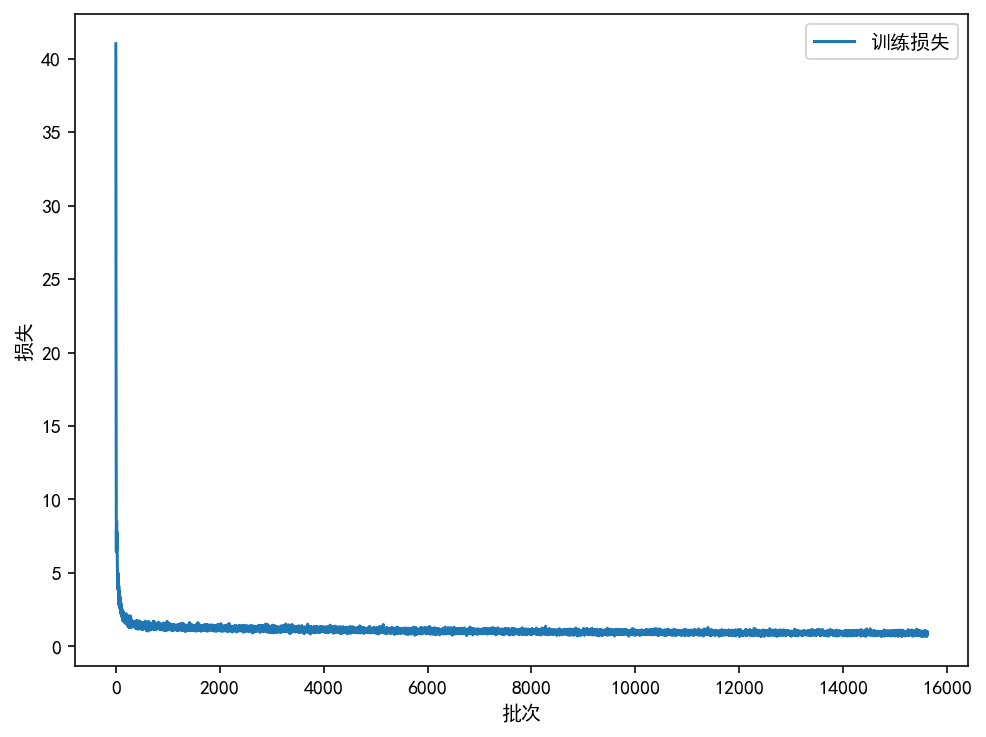

In [33]:
from pylab import *
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

plt.figure(figsize=(8,6))
plt.plot(losses['train'], label='训练损失')
plt.legend()
plt.xlabel("批次")
plt.ylabel("损失")
_ = plt.ylim()

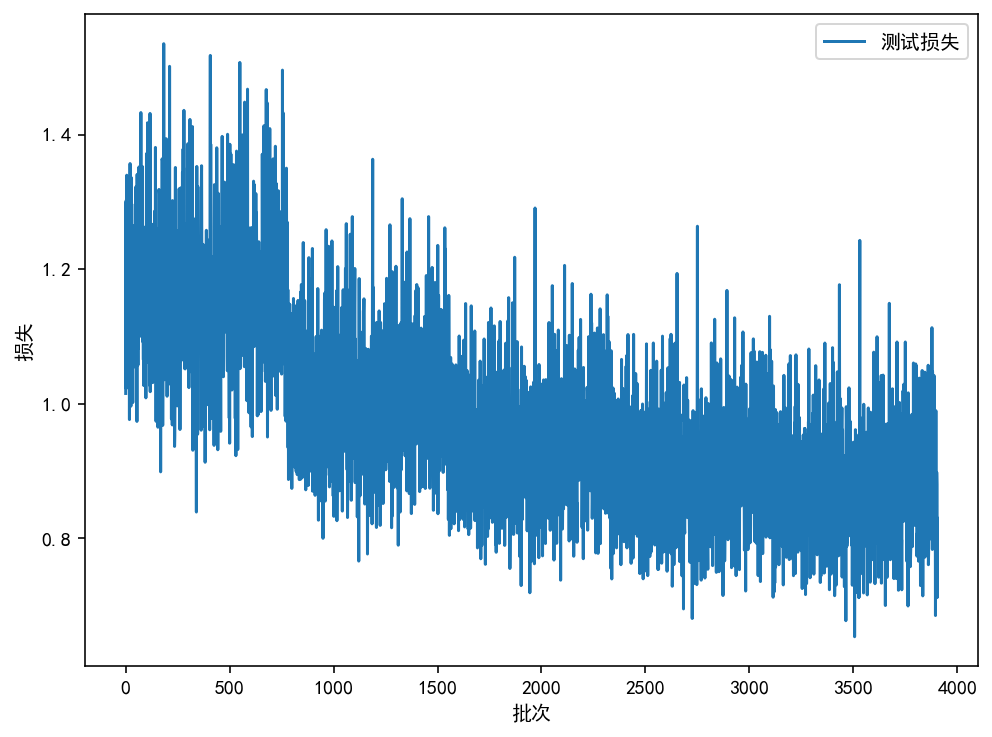

In [34]:
plt.figure(figsize=(8,6))
plt.plot(losses['test'], label='测试损失')
plt.legend()
plt.xlabel("批次")
plt.ylabel("损失")
_ = plt.ylim()

In [25]:
def get_tensors(loaded_graph):
    '''
    使用 get_tensor_by_name() 函数从 loaded_graph 中获取tensors
    '''
    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0")
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat


In [26]:
loaded_graph = tf.Graph()
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:
    # 载入保存好的模型
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # 调用函数拿到 tensors
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,
            movie_titles: titles,
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)
        # 添加进一个list中
        movie_matrics.append(movie_combine_layer_flat_val)
# 保存成 .p 文件
pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
# 读取文件
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./save


In [27]:
loaded_graph = tf.Graph()
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:
    # 载入保存好的模型
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # 调用函数拿到 tensors
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        # 添加进一个list中
        users_matrics.append(user_combine_layer_flat_val)
# 保存成 .p 文件
pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
# 读取文件
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [28]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [29]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    
    # 推荐看过同一个的电影的人喜欢的电影
    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
    # 根据电影寻找相似的人
    probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_movie_embeddings = probs_movie_embeddings/np.sqrt(np.sum(np.square(probs_movie_embeddings)))
    
    norm_users_matrics = np.sqrt(np.sum(np.square(users_matrics),axis=1)).reshape(6040,1)
    normalized_users_matrics = users_matrics/norm_users_matrics
    probs_user_favorite_similarity = np.matmul(probs_movie_embeddings, np.transpose(normalized_users_matrics))
    
    favorite_user_id = np.argsort(probs_user_favorite_similarity)[0][-top_k:]
    print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
    # 他们喜欢什么样的电影
    probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
    probs_users_embeddings = probs_users_embeddings/np.sqrt(np.sum(np.square(probs_users_embeddings)))
    
    norm_movie_matrics = np.sqrt(np.sum(np.square(movie_matrics),axis=1)).reshape(3883,1)
    normalized_movie_matrics = movie_matrics/norm_movie_matrics
    probs_similarity = np.matmul(probs_users_embeddings, np.transpose(normalized_movie_matrics))
    p = np.argmax(probs_similarity, 1)
    print("喜欢看这个电影的人还喜欢看：")
    
    results = set()
    while len(results) != 5:
        c = p[random.randrange(top_k)]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results